# Logistic Regression with K-Means clusters

**An experimental algorithm to cluster data and feature engineering based on "anomalies" in the data**

To ease the development of the algorithm, a class and multiple functions have been created. This will aid in time consuming tasks.

Redudant imports exists, which sole reason is for further experimentation.

In [12]:
from azureml.core import Workspace, Datastore, Dataset
from azureml.core.model import Model

from azureml.core.experiment import Experiment

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pandas.plotting import parallel_coordinates

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import joblib


**Get data from Azure Machine Learning ressource and storage accounts**

In [23]:
#ws = Workspace.from_config("../config/config")
ws = Workspace.get(name="AzureML02WP",
               subscription_id='5e20a2e2-7522-4cb5-957f-ce42d9c2abfd',
               resource_group='AzureML02')
ws
az_store = Datastore.get(ws, 'blob01')
az_dataset = Dataset.get_by_name(ws, "petrosani")
#az_dataset_Turda = Dataset.get_by_name(ws, "Turda_01")
az_default_store = ws.get_default_datastore()
df = az_dataset.to_pandas_dataframe()
#df_Turda_ = az_dataset_Turda.to_pandas_dataframe()

**Log the run**

In [25]:
experiment = Experiment(workspace=ws, name='Clustering_Petro')
new_run = experiment.start_logging()

**Setup tools**

In [26]:
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()


def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P


# class for loading, initializing and training a logistic model with Kmeans clusters.
class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data[['Temp_Out', 'Temp_Room', 'FanSpeed']])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data['Abnormality'], test_size=0.3, random_state=42)
        
    def cmPlot(df):
        return plotCorrelationMatrix(df, 5)
        
    def __init__(self, sklearn_load_ds):
        self._load_data(sklearn_load_ds)
    
    
    def classify(self, model=LogisticRegression(random_state=42, warm_start=True, class_weight=2)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))


    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

Raw data exploration

- Correlation matrix plotted, to observe any correlation in the raw data. 
- Transpose method used to get a statistical overview of the data.

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


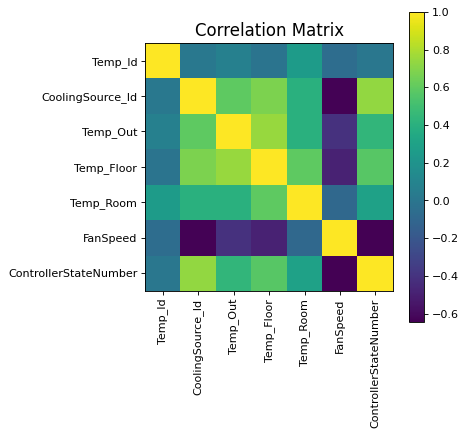

In [ ]:
plotCorrelationMatrix(df, 5)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp_Id,333629.0,1.848537e+06,710508.936198,196603.0,1240763.0,2145407.0,2537575.0,2754019.0
Location_Id,333629.0,2.069000e+03,0.000000,2069.0,2069.0,2069.0,2069.0,2069.0
CoolingSource_Id,333629.0,1.050688e-01,0.338319,0.0,0.0,0.0,0.0,2.0
Temp_Out,333629.0,9.744159e+00,8.933181,-19.8,2.7,8.7,15.6,43.0
Temp_Floor,333629.0,1.684418e+01,2.882096,6.2,14.9,16.2,17.4,30.9
Temp_Room,333629.0,2.559568e+01,1.027625,18.0,25.0,25.5,26.0,32.9
FanSpeed,333629.0,5.608807e+01,18.045047,0.0,54.0,59.0,64.0,90.0
ControllerStateNumber,333629.0,8.647105e+00,6.617204,4.0,7.0,7.0,7.5,84.0


**Create new features based on existing data**

This process is to get an indication of what can be classified as an anomali, for further use in the Regression Algorithm

In [27]:
alldatestart = '2021-01-01'
alldateend = '2021-12-31'

# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_anom = df.loc[mask]
temp_threshhold = 10
fanspeed_threshhold = 15



# define temperatur difference indicator
df_anom['RoomTempHigher'] = np.where(df_anom['Temp_Room'] > (df_anom['Temp_Out'] - temp_threshhold), 1, 0)
df_anom['TempDifFromMean'] = np.where((df_anom['Temp_Room'] - df_anom['Temp_Out']) > (df_anom['Temp_Room'].mean() - (df_anom['Temp_Out'].mean() + temp_threshhold)), 1, 0)

# define fanspeed difference from mean indicator
df_anom['FanSpeedHigherThanMean'] = np.where(df_anom['FanSpeed'] > (df_anom['FanSpeed'].mean() + fanspeed_threshhold), 1, 0)

# define abnormality from above features
df_anom['Abnormality'] = np.where(((df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1)), 1, 0)


df_anom['TempDiff'] = np.where(((df_anom['Temp_Room'] > df_anom['Temp_Out'])), df_anom['Temp_Room'] - df_anom['Temp_Out'], 0)
df_anom['FanFreq'] = np.where(((df_anom['FanSpeed'] > df_anom['FanSpeed'].mean())), df_anom['FanSpeed'] - df_anom['FanSpeed'].mean(), 0)

# define arobs
conditions = [
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 0),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 0)
    ]
values = [1, 0, 0, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
df_anom['Arobs'] = np.select(conditions, values)

# ref all columns
data_colums = df_anom.select_dtypes(include='number').columns


C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


df_test = df_anom.copy()

scaler_fitted = scaler.fit(df_test[data_colums])
df_test[data_colums] = scaler_fitted.transform(df_test[data_colums])



###
obj_file = './testdata/scaler.pkl'
joblib.dump(value=scaler_fitted, filename=obj_file)



['./testdata/scaler.pkl']

In [ ]:
df_test2 = df_anom.copy()
sc = joblib.load(obj_file)
df_test2[data_colums] = sc.transform(df_test2[data_colums])
df_test2


,Temp_Id,Date_Id,Location_Id,CoolingSource_Id,Temp_Out,Temp_Floor,Temp_Room,FanSpeed,ControllerStateNumber,RoomTempHigher,TempDifFromMean,FanSpeedHigherThanMean,Abnormality,TempDiff,FanFreq,Arobs
31,0.000000e+00,2021-01-01 00:02:00,0.0,0.0,0.316547,0.320988,0.426573,0.633333,0.04375,1.0,1.0,0.0,0.0,0.522546,0.049120,0.0
32,4.955959e-07,2021-01-01 00:04:00,0.0,0.0,0.316547,0.308642,0.503497,0.755556,0.04375,1.0,1.0,0.0,0.0,0.551724,0.366080,0.0
33,9.911918e-07,2021-01-01 00:06:00,0.0,0.0,0.316547,0.308642,0.482517,0.722222,0.04375,1.0,1.0,0.0,0.0,0.543767,0.279637,0.0
34,1.486788e-06,2021-01-01 00:08:00,0.0,0.0,0.316547,0.316872,0.489510,0.733333,0.04375,1.0,1.0,0.0,0.0,0.546419,0.308451,0.0
35,1.982384e-06,2021-01-01 00:10:00,0.0,0.0,0.316547,0.325103,0.482517,0.722222,0.04375,1.0,1.0,0.0,0.0,0.543767,0.279637,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235810,9.999980e-01,2021-11-30 22:51:00,0.0,0.0,0.212230,0.345679,0.524476,0.688889,0.04375,1.0,1.0,0.0,0.0,0.713528,0.193193,0.0
235811,9.999985e-01,2021-11-30 22:53:00,0.0,0.0,0.215827,0.353909,0.524476,0.688889,0.04375,1.0,1.0,0.0,0.0,0.708223,0.193193,0.0
235812,9.999990e-01,2021-11-30 22:55:00,0.0,0.0,0.215827,0.370370,0.538462,0.711111,0.04375,1.0,1.0,0.0,0.0,0.713528,0.250822,0.0
235813,9.999995e-01,2021-11-30 22:57:00,0.0,0.0,0.219424,0.386831,0.531469,0.700000,0.04375,1.0,1.0,0.0,0.0,0.705570,0.222008,0.0


Explore new features in statistical format and

In [ ]:
select_df = df_anom.drop(['Location_Id', 'Date_Id', 'Arobs', 'Temp_Id'], 1)

select_df.describe().transpose()

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
CoolingSource_Id,235784.0,0.136057,0.378323,0.0,0.0,0.000000,0.000000,2.000000
Temp_Out,235784.0,11.315058,9.053788,-12.6,4.2,10.500000,17.100000,43.000000
Temp_Floor,235784.0,17.261849,3.114469,6.6,15.1,16.500000,18.100000,30.900000
Temp_Room,235784.0,25.530122,1.130687,18.6,24.8,25.400000,25.900000,32.900000
FanSpeed,235784.0,55.295291,20.455000,0.0,54.0,59.000000,64.000000,90.000000
ControllerStateNumber,235784.0,9.081774,7.389760,4.0,7.0,7.000000,7.500000,84.000000
RoomTempHigher,235784.0,0.995593,0.066236,0.0,1.0,1.000000,1.000000,1.000000
TempDifFromMean,235784.0,0.894853,0.306743,0.0,1.0,1.000000,1.000000,1.000000
FanSpeedHigherThanMean,235784.0,0.091308,0.288047,0.0,0.0,0.000000,0.000000,1.000000
Abnormality,235784.0,0.091308,0.288047,0.0,0.0,0.000000,0.000000,1.000000


**Explore cluster K-means algorithm**

In [ ]:
X = StandardScaler().fit_transform(select_df)

kmeans = KMeans(n_clusters=2)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=2)


In [ ]:
centers = model.cluster_centers_
centers

array([[-0.35540558, -0.24836251, -0.28067764, -0.16870578,  0.29397556,
        -0.30494733,  0.06652879,  0.32984234, -0.00768264, -0.00768264,
         0.22261665,  0.05289834],
       [ 2.55964463,  1.78871638,  2.02145114,  1.21502549, -2.11722332,
         2.19624237, -0.47914288, -2.37553723,  0.05533068,  0.05533068,
        -1.60329369, -0.38097586]])

In [ ]:
P = pd_centers(select_df, centers)
P

,CoolingSource_Id,Temp_Out,Temp_Floor,Temp_Room,FanSpeed,ControllerStateNumber,RoomTempHigher,TempDifFromMean,FanSpeedHigherThanMean,Abnormality,TempDiff,FanFreq,prediction
0,-0.355406,-0.248363,-0.280678,-0.168706,0.293976,-0.304947,0.066529,0.329842,-0.007683,-0.007683,0.222617,0.052898,0
1,2.559645,1.788716,2.021451,1.215025,-2.117223,2.196242,-0.479143,-2.375537,0.055331,0.055331,-1.603294,-0.380976,1


**Plotting out scaled values and define cluster**

Plotted values are fanspeed and out temps. The line indicates the two different clusters, which will be used for classification.

(-1.0, 1.5)

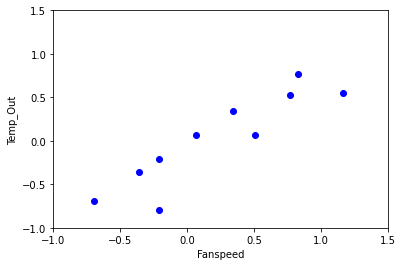

In [ ]:
plt.scatter(X[10], X[5], c='b')

plt.xlabel('Fanspeed')
plt.ylabel('Temp_Out')
plt.title(label="")
plt.ylim(-1,1.5)
plt.xlim(-1,1.5)

(-1.0, 1.5)

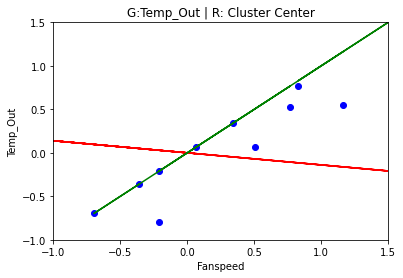

In [ ]:
plt.scatter(X[10], X[5], c='b')
plt.plot(centers[1], centers[0], c='r')
plt.plot(X[10], X[10], c='g')

plt.xlabel('Fanspeed')
plt.ylabel('Temp_Out')
plt.title(label="G:Temp_Out | R: Cluster Center")
plt.ylim(-1,1.5)
plt.xlim(-1,1.5)

In [60]:
clus = clust(sklearn_load_ds=select_df)

result = clus.Kmeans(output='replace').classify()

Accuracy: 0.9077273241348112


In [59]:
clu = clust

In [62]:
z = clu(sklearn_load_ds=select_df)

resu = z.Kmeans(output='replace').classify()

Accuracy: 0.9077273241348112


# Deployment configurations

**Log result**

In [ ]:
new_run.log('accuracy', result)

**Dump model to output folder and log status**

In [7]:
model_files = './outputs/clust_01_01.pkl'
clu = clust

joblib.dump(value=[df.columns,clu], filename=model_files)



new_run.complete()

['./outputs/clust_01_01.pkl']

**Register model by using the outputted file. The rest is optional to describe the model.**

In [29]:
new_run.register_model(model_path='outputs/clust_01_01.pkl',
                       model_name='CLA01', 
                       tags={'source': 'SDK-Run', 'algorithm': 'Cluster'},
                       description='Cluster algorithm for regressional predictions')

Model(workspace=Workspace.create(name='AzureML02WP', subscription_id='5e20a2e2-7522-4cb5-957f-ce42d9c2abfd', resource_group='AzureML02'), name=CLA01, id=CLA01:1, version=1, tags={'source': 'SDK-Run', 'algorithm': 'Cluster'}, properties={})

**Environment configuration**

In [30]:
# environment
from azureml.core import Environment
from azureml.core.environment import CondaDependencies

myenv = Environment(name='ClusterPetroEnvironment_01')
python_packages = ['pandas']
for package in python_packages:
    myenv.python.conda_dependencies.add_pip_package(package)

myenv_dep = CondaDependencies.create(conda_packages=['scikit-learn', 'pip'],
                                     pip_packages=['azureml-defaults'])

myenv.python.conda_dependencies = myenv_dep

myenv.register(ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20220412.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "ClusterPetroEnvironment_01",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "

**Configure compute targets**

In [31]:
from azureml.core.compute import AksCompute
from azureml.core.compute import ComputeTarget

cluster_name = 'aks-cluster-001'

if cluster_name not in ws.compute_targets:
    aks_config = AksCompute.provisioning_configuration(location='westeurope',
                                                    vm_size='Standard_DS2_v2',
                                                    agent_count=1,
                                                    cluster_purpose='DevTest', compute_type='Managed')

    production_cluster = ComputeTarget.create(ws, cluster_name, aks_config)

    production_cluster.wait_for_completion(show_output=True)
else:
        production_cluster = ws.compute_targets[cluster_name]

InProgress........................................................
SucceededProvisioning operation finished, operation "Succeeded"


**Inference pipeline configuration**

In [32]:
from azureml.core.model import InferenceConfig

_inference_config = InferenceConfig(environment=myenv, 
                                   entry_script='scoring_script.py',
                                   source_directory='../source')

**Deployment configuration**

In [34]:
from azureml.core.webservice import AksWebservice

deploy_config = AksWebservice.deploy_configuration(cpu_cores=1,
                                                   memory_gb=1)

In [ ]:
from azureml.core.model import Model

# models to deploy to service
models = ws.models['CLA01']

service = Model.deploy(workspace=ws,
                       name='cka-service-05',
                       models=[models],
                       inference_config=_inference_config,
                       deployment_config=deploy_config,
                       deployment_target=production_cluster
                       )

service.wait_for_deployment(show_output=True)